In [37]:
import torch
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from src.model.models import MLP
from src.data.helpers import list_to_model, get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [38]:
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)

        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.w0 = self.weights[self.dataset["angle"] == 0].values
        self.w45 = self.weights[self.dataset["angle"] == 45].values
        self.w90 = self.weights[self.dataset["angle"] == 90].values
        self.w135 = self.weights[self.dataset["angle"] == 135].values
        self.w180 = self.weights[self.dataset["angle"] == 180].values
        self.w225 = self.weights[self.dataset["angle"] == 225].values
        self.w270 = self.weights[self.dataset["angle"] == 270].values
        self.w315 = self.weights[self.dataset["angle"] == 315].values
    
        self.angles = self.dataset["angle"]

    def __len__(self):
        return len(self.w0)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        t0 = torch.tensor(self.w0[idx])
        t45 = torch.tensor(self.w45[idx])
        t90 = torch.tensor(self.w90[idx])
        t135 = torch.tensor(self.w135[idx])
        t180 = torch.tensor(self.w180[idx])
        t225 = torch.tensor(self.w225[idx])
        t270 = torch.tensor(self.w270[idx])
        t315 = torch.tensor(self.w315[idx])

        return (t0, t45, t90, t135, t180, t225, t270, t315)

In [39]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 16),
            torch.nn.Tanh(),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 33),
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [40]:
config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 1024, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [41]:
path = "../models/autoencoders/experiment6"

In [42]:
autoencoder.train()
for i in tqdm(range(epochs)):
    for w0, w45, w90, w135, w180, w225, w270, w315 in dataloader:
        w0 = w0.to(device)
        w45 = w45.to(device)
        w90 = w90.to(device)
        w135 = w135.to(device)
        w180 = w180.to(device)
        w225 = w225.to(device)
        w270 = w270.to(device)
        w315 = w315.to(device)

        l0 = autoencoder.encoder(w0)
        l45 = autoencoder.encoder(w45)
        l90 = autoencoder.encoder(w90)
        l135 = autoencoder.encoder(w135)
        l180 = autoencoder.encoder(w180)
        l225 = autoencoder.encoder(w225)
        l270 = autoencoder.encoder(w270)
        l315 = autoencoder.encoder(w315)

        o0 = autoencoder.decoder(l0)
        o45 = autoencoder.decoder(l45)
        o90 = autoencoder.decoder(l90)
        o135 = autoencoder.decoder(l135)
        o180 = autoencoder.decoder(l180)
        o225 = autoencoder.decoder(l225)
        o270 = autoencoder.decoder(l270)
        o315 = autoencoder.decoder(l315)

        rl0 = loss_fn(o0, w0)
        rl45 = loss_fn(o45, w45)
        rl90 = loss_fn(o90, w90)
        rl135 = loss_fn(o135, w135)
        rl180 = loss_fn(o180, w180)
        rl225 = loss_fn(o225, w225)
        rl270 = loss_fn(o270, w270)
        rl315 = loss_fn(o315, w315)
        rl = rl0 + rl45 + rl90 + rl135 + rl180 + rl225 + rl270 + rl315

        # lg0 = (l315 + l45)/2
        # lg45 = (l0 + l90)/2
        # lg90 = (l45 + l135)/2
        # lg135 = (l90 + l180)/2
        # lg180 = (l135 + l225)/2
        # lg225 = (l180 + l270)/2
        # lg270 = (l225 + l315)/2
        # lg315 = (l270 + l0)/2

        # ll0 = loss_fn(l0, lg0)
        # ll45 = loss_fn(l45, lg45)
        # ll90 = loss_fn(l90, lg90)
        # ll135 = loss_fn(l135, lg135)
        # ll180 = loss_fn(l180, lg180)
        # ll225 = loss_fn(l225, lg225)
        # ll270 = loss_fn(l270, lg270)
        # ll315 = loss_fn(l315, lg315)
        # ll = ll0 + ll45 + ll90 + ll135 + ll180 + ll225 + ll270 + ll315
        ll = 0

        cos0 = torch.cos(torch.tensor([0*np.pi/180]))
        cos45 = torch.cos(torch.tensor([45*np.pi/180]))
        cos90 = torch.cos(torch.tensor([90*np.pi/180]))
        cos135 = torch.cos(torch.tensor([135*np.pi/180]))
        cos180 = torch.cos(torch.tensor([180*np.pi/180]))
        cos225 = torch.cos(torch.tensor([225*np.pi/180]))
        cos270 = torch.cos(torch.tensor([270*np.pi/180]))
        cos315 = torch.cos(torch.tensor([315*np.pi/180]))

        sin0 = torch.sin(torch.tensor([0*np.pi/180]))
        sin45 = torch.sin(torch.tensor([45*np.pi/180]))
        sin90 = torch.sin(torch.tensor([90*np.pi/180]))
        sin135 = torch.sin(torch.tensor([135*np.pi/180]))
        sin180 = torch.sin(torch.tensor([180*np.pi/180]))
        sin225 = torch.sin(torch.tensor([225*np.pi/180]))
        sin270 = torch.sin(torch.tensor([270*np.pi/180]))
        sin315 = torch.sin(torch.tensor([315*np.pi/180]))

        lf0 = l0.clone()
        lf0[:, 0] = sin0
        lf0[:, 1] = cos0

        lf45 = l45.clone()
        lf45[:, 0] = sin45
        lf45[:, 1] = cos45

        lf90 = l90.clone()
        lf90[:, 0] = sin90
        lf90[:, 1] = cos90

        lf135 = l135.clone()
        lf135[:, 0] = sin135
        lf135[:, 1] = cos135

        lf180 = l180.clone()
        lf180[:, 0] = sin180
        lf180[:, 1] = cos180

        lf225 = l225.clone()
        lf225[:, 0] = sin225
        lf225[:, 1] = cos225

        lf270 = l270.clone()
        lf270[:, 0] = sin270
        lf270[:, 1] = cos270

        lf315 = l315.clone()
        lf315[:, 0] = sin315
        lf315[:, 1] = cos315

        lfl0 = loss_fn(lf0, l0)
        lfl45 = loss_fn(lf45, l45)
        lfl90 = loss_fn(lf90, l90)
        lfl135 = loss_fn(lf135, l135)
        lfl180 = loss_fn(lf180, l180)
        lfl225 = loss_fn(lf225, l225)
        lfl270 = loss_fn(lf270, l270)
        lfl315 = loss_fn(lf315, l315)
        lfl = lfl0 + lfl45 + lfl90 + lfl135 + lfl180 + lfl225 + lfl270 + lfl315


        loss = rl + ll + lfl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"{path}/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"{path}/autoencoder_final.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 20.404579162597656
Epoch: 6, Loss: 8.027588844299316
Epoch: 11, Loss: 6.076474189758301
Epoch: 16, Loss: 5.017822742462158
Epoch: 21, Loss: 4.795917510986328
Epoch: 26, Loss: 4.695252895355225
Epoch: 31, Loss: 4.2045159339904785
Epoch: 36, Loss: 4.012467384338379
Epoch: 41, Loss: 3.9826416969299316
Epoch: 46, Loss: 3.683112144470215
Epoch: 51, Loss: 3.6041059494018555
Epoch: 56, Loss: 3.5301706790924072
Epoch: 61, Loss: 3.4843523502349854
Epoch: 66, Loss: 3.35707688331604
Epoch: 71, Loss: 3.227842092514038
Epoch: 76, Loss: 3.2410125732421875
Epoch: 81, Loss: 3.358039617538452
Epoch: 86, Loss: 3.2320964336395264
Epoch: 91, Loss: 3.138221025466919
Epoch: 96, Loss: 3.093777656555176


(80000, 16)
(80000, 3)


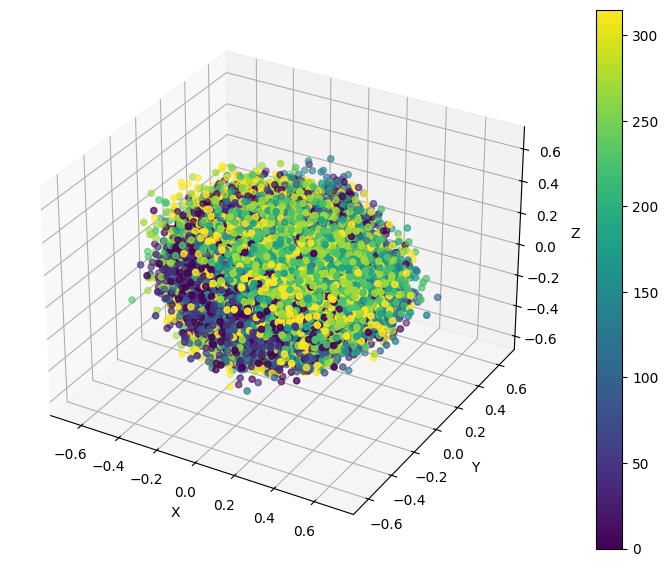

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 50
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

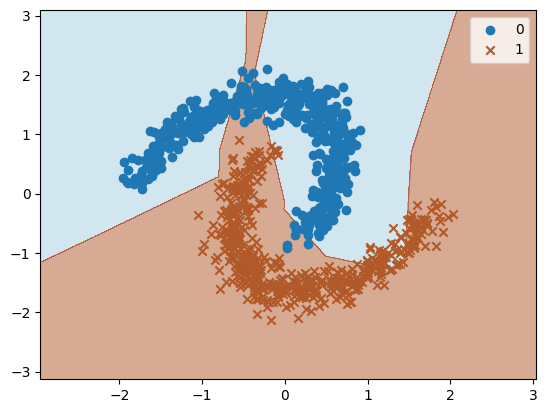

In [28]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model = MLP(2, [8], 1)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

w0 = weights[angles == 0]
w45 = weights[angles == 90]

index = 5
alpha = 0.3
w = torch.tensor( (1-alpha)*w0[index] + alpha*w45[index] ).unsqueeze(0).float()
a = (1-alpha)*0 + alpha*90

X_rotated = rotate(X, a)

o = autoencoder(w).squeeze().detach().numpy()
list_to_model(model, o)

plot_decision_boundary(model, X_rotated, y)